In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.sparse import csr_matrix
import anndata as ad

## preprocess both files supplied in GEO in bash

## read in sample/cell info

In [4]:
pts = pd.read_table("/data/rna_rep_learning/sadefeldman/GSE120575_processed_metadata.txt")

In [5]:
pts['characteristics: therapy'].value_counts()

anti-PD1          11653
anti-CTLA4+PD1     4121
anti-CTLA4          517
Name: characteristics: therapy, dtype: int64

#### drop empty columns

In [6]:
#check that all are empty
(~pts.loc[:,'molecule':'Unnamed: 34'].isna()).sum() 

molecule                0
description             0
processed data file     0
raw file                0
Unnamed: 11             0
Unnamed: 12             0
Unnamed: 13             0
Unnamed: 14             0
Unnamed: 15             0
Unnamed: 16             0
Unnamed: 17             0
Unnamed: 18             0
Unnamed: 19             0
Unnamed: 20             0
Unnamed: 21             0
Unnamed: 22             0
Unnamed: 23             0
Unnamed: 24             0
Unnamed: 25             0
Unnamed: 26             0
Unnamed: 27             0
Unnamed: 28             0
Unnamed: 29             0
Unnamed: 30             0
Unnamed: 31             0
Unnamed: 32             0
Unnamed: 33             0
Unnamed: 34             0
dtype: int64

In [7]:
# drop
pts.drop(columns=pts.columns[7:], inplace=True)

In [8]:
len(pd.unique(pts.title))

16291

## clean up column names, drop meaningless columns

In [9]:
pts.drop(columns=["Sample name","organism","source name"], inplace=True)

In [10]:
pts.columns

Index(['title',
       'characteristics: patinet ID (Pre=baseline; Post= on treatment)',
       'characteristics: response', 'characteristics: therapy'],
      dtype='object')

In [11]:
pts.rename(columns={'title':'cellid',
       'characteristics: patinet ID (Pre=baseline; Post= on treatment)':"pid",
       'characteristics: response':"response", 'characteristics: therapy':"therapy"}, inplace=True)

In [12]:
import os
os.path.dirname("/data/rna_rep_learning/sadefeldman/processed_adata_sparse.h5ad")

'/data/rna_rep_learning/sadefeldman'

## read in gene expression data

In [13]:
adata_orig = sc.read_csv("/data/rna_rep_learning/sadefeldman/GSE120575_processed_TPM.txt", delimiter="\t", first_column_names=True)

In [14]:
# need to tranpose adata
adata = ad.AnnData(np.transpose(adata_orig.X), obs = adata_orig.var.copy(), var=adata_orig.obs.copy())

del adata_orig

In [15]:
print(len(pd.merge(pts, adata.obs, right_index=True, left_on="cellid")))
print(len(pts))
print(len(adata.obs))

##all same length, so ready to merge

16291
16291
16291


In [16]:
adata.obs = pd.merge(pts, adata.obs, right_index=True, left_on="cellid").set_index("cellid")

## convert adata to sparse format -- much more efficient for memory and esp writing to disk

In [17]:
adata.X = csr_matrix(adata.X)

In [18]:
adata

AnnData object with n_obs × n_vars = 16291 × 55737
    obs: 'pid', 'response', 'therapy'

## should I limit to ~20K protein coding genes they used in their analysis? didnt in the end (see table S6 in paper)

In [19]:
proteincoding = pd.read_csv("sadefeldman_extras/sadefeldman_proteincoding_tableS6.csv")

In [20]:
adata = adata[:,adata.var.index.isin(proteincoding['Gene Name'])]
adata

View of AnnData object with n_obs × n_vars = 16291 × 20645
    obs: 'pid', 'response', 'therapy'

## Scanpy preprocessing

/opt/conda/rpeyser/envs/scset3/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


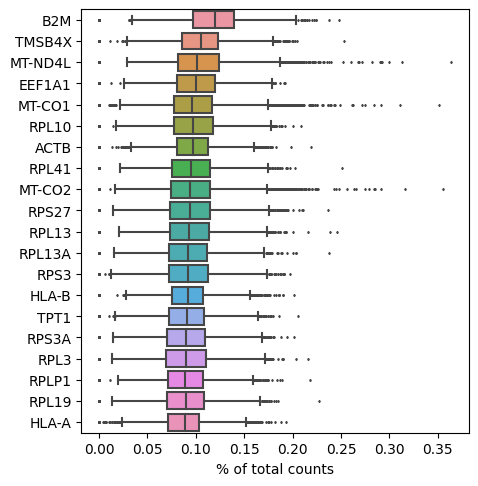

In [21]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [22]:
sc.pp.filter_cells(adata, min_genes=1000) #dont expect to remove any bc these are same thresholds as used in paper
adata

AnnData object with n_obs × n_vars = 16291 × 20645
    obs: 'pid', 'response', 'therapy', 'n_genes'

In [23]:
sc.pp.filter_genes(adata, min_cells=15)
adata

AnnData object with n_obs × n_vars = 16291 × 18136
    obs: 'pid', 'response', 'therapy', 'n_genes'
    var: 'n_cells'

In [24]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, inplace=True)

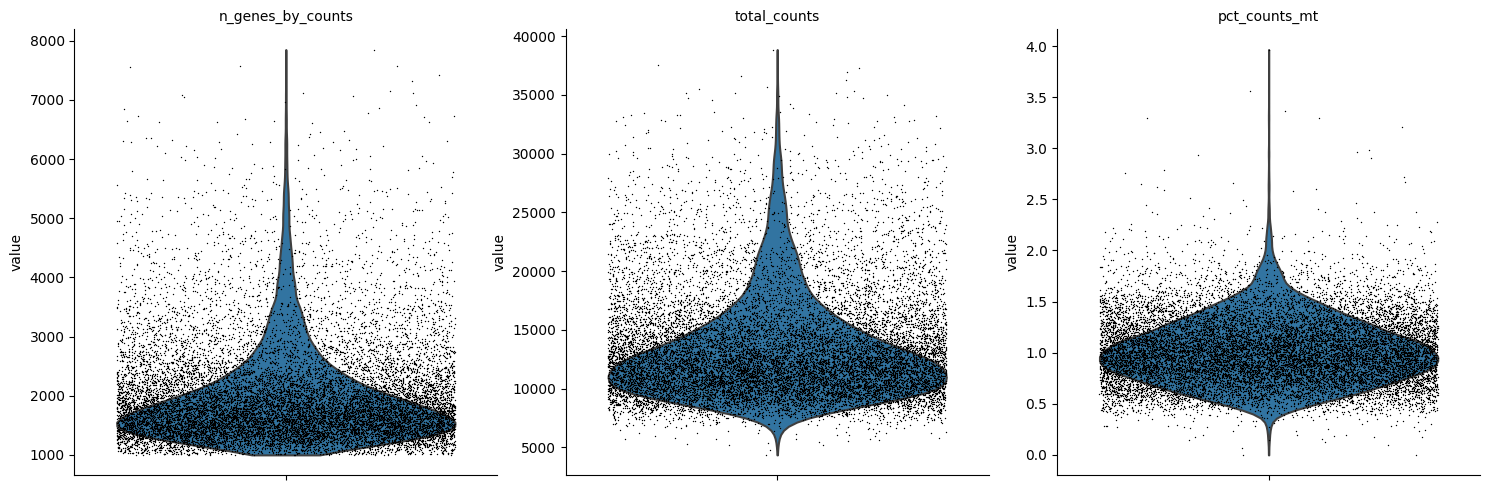

In [25]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

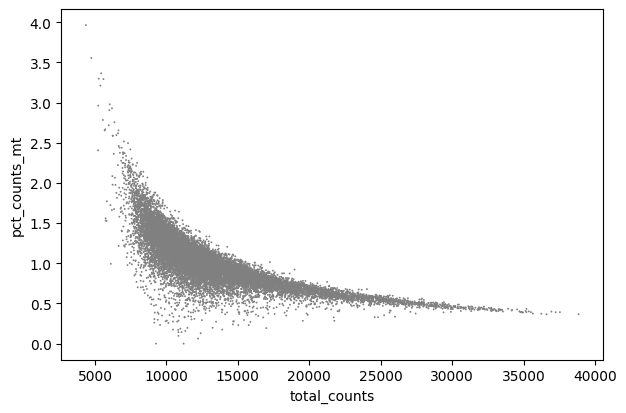

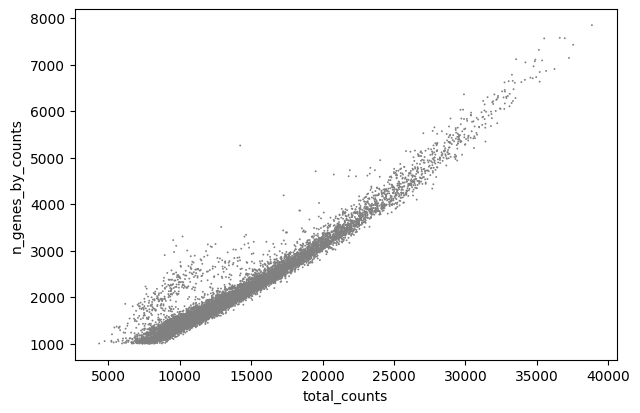

In [26]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

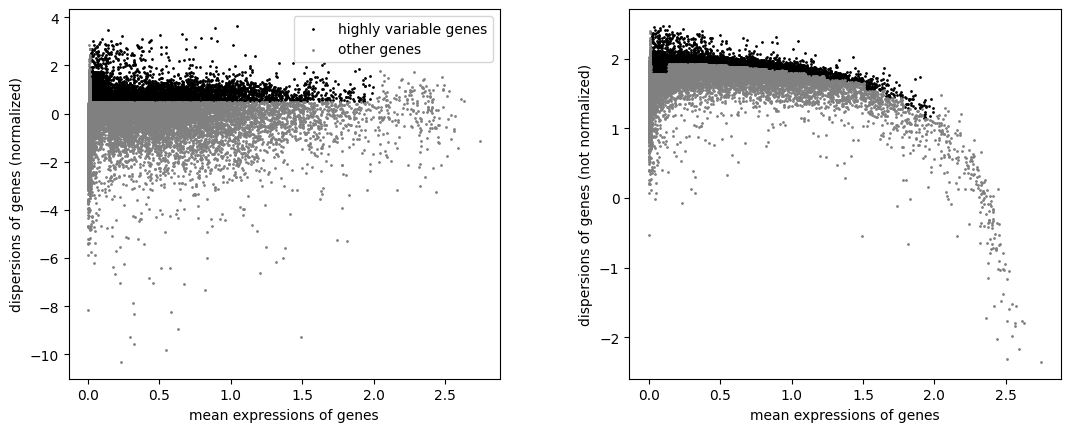

In [27]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=2, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [28]:
sc.pp.scale(adata, max_value=10)

In [29]:
sc.tl.pca(adata, svd_solver='arpack')

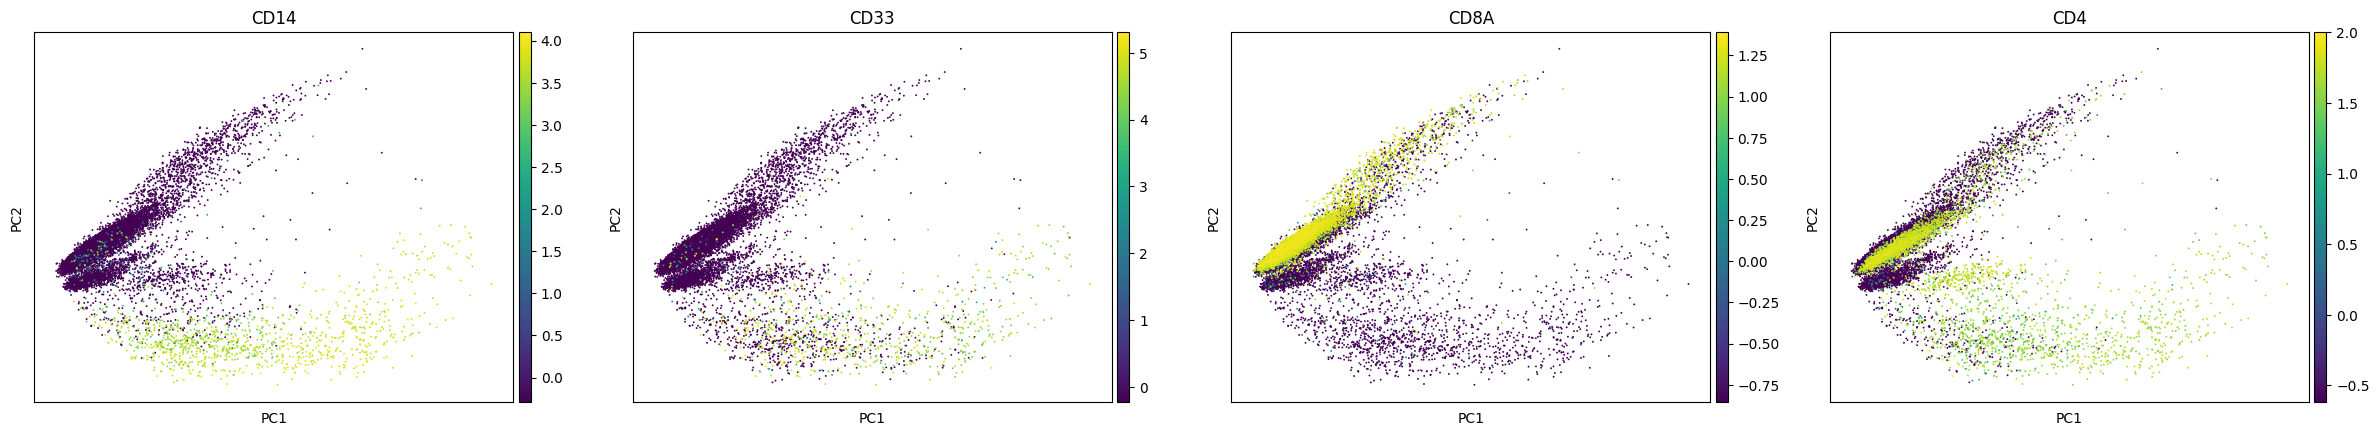

In [30]:
sc.pl.pca(adata, color=['CD14','CD33','CD8A','CD4'])

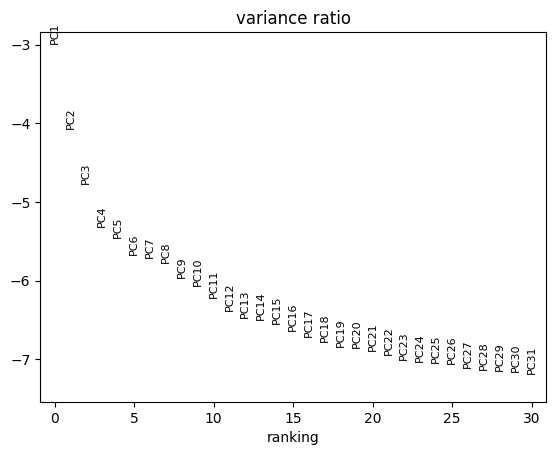

In [31]:
sc.pl.pca_variance_ratio(adata, log=True)

In [32]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)

In [33]:
sc.tl.umap(adata)

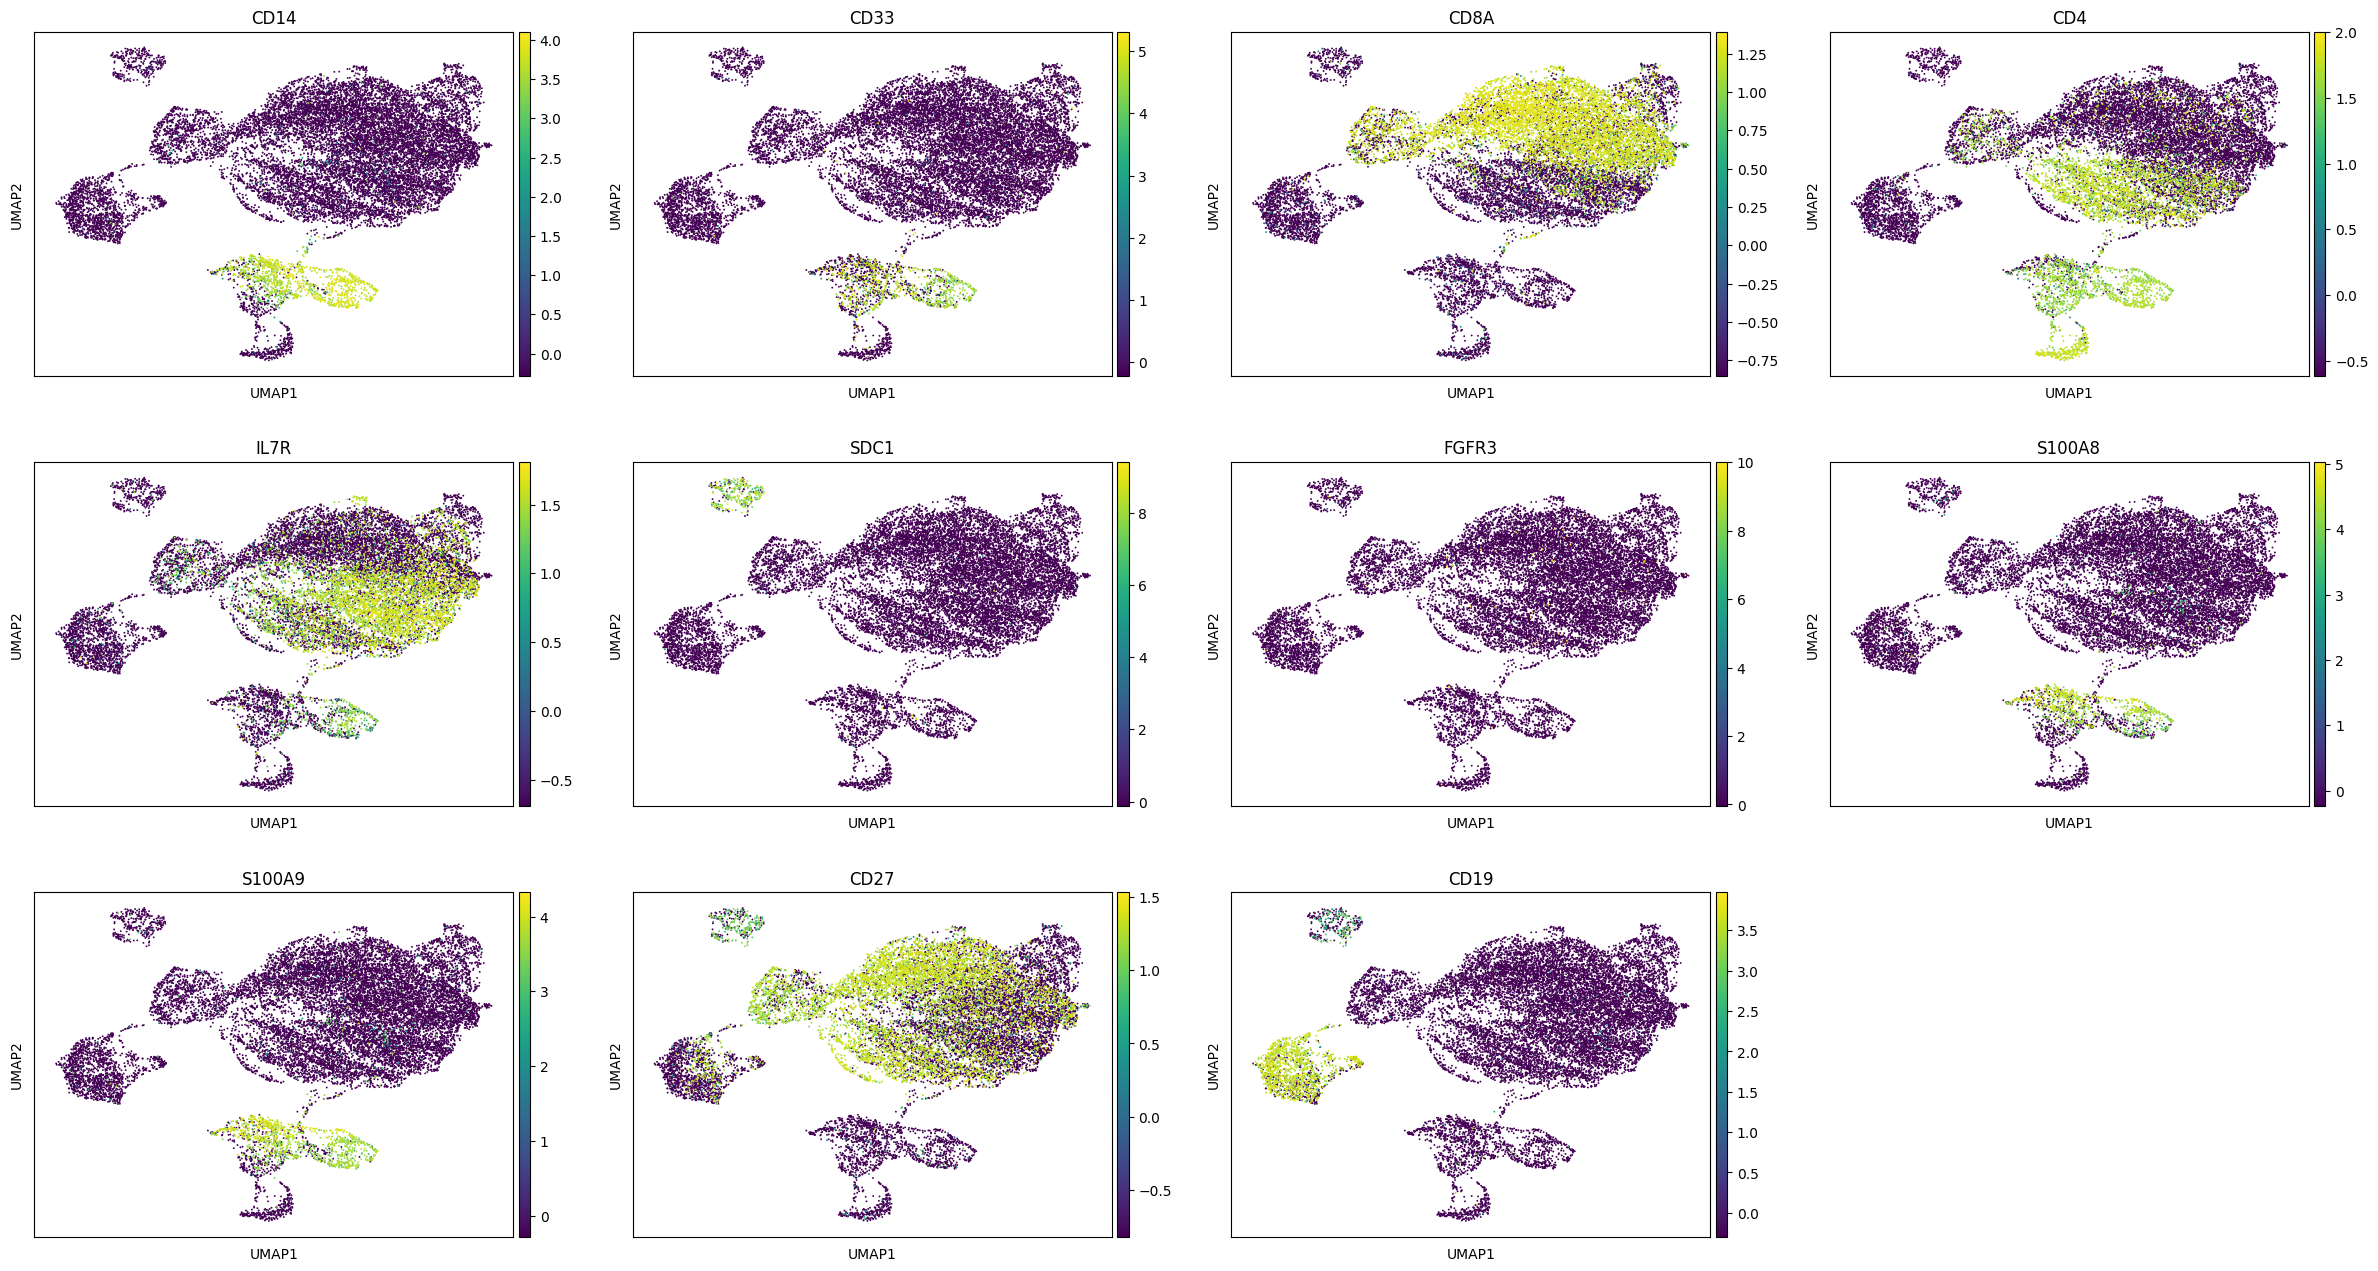

In [34]:
sc.pl.umap(adata, color=['CD14','CD33','CD8A','CD4','IL7R','SDC1','FGFR3','S100A8','S100A9','CD27','CD19'])

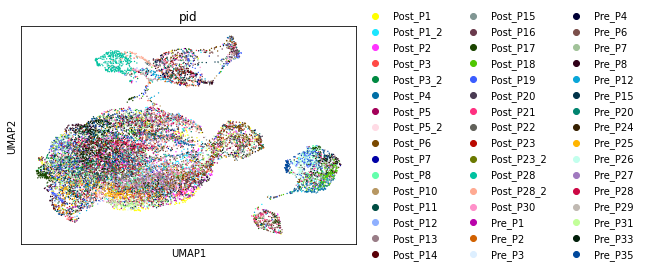

In [85]:
sc.pl.umap(adata, color='pid')

In [95]:
adata.obs.groupby("pid").size().max()

675

In [35]:
adata.obs.pid.value_counts().max()

675

In [106]:
type(adata.obsm['X_pca'][:,:2])

numpy.ndarray

## write to file

In [37]:
adata.write("/data/rna_rep_learning/sadefeldman/processed_adata_sparse.h5ad")

In [38]:
adata = sc.read("/data/rna_rep_learning/sadefeldman/processed_adata_sparse.h5ad")